# Comparative Analysis of Collaborative Filtering and Matrix Factorization Techniques in MovieLens Recommender Systems

# Collaborative Filtering

In [1]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error
from math import sqrt
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import GridSearchCV


# Load the datasets
base_columns = ['user_id', 'item_id', 'rating', 'timestamp']
test_columns = ['user_id', 'item_id', 'rating', 'timestamp']

# Load the base dataset
movielens_base = pd.read_csv('/Users/ninasimone/movielens_100k.base', sep='\t', names=base_columns)

# Load the test dataset
movielens_test = pd.read_csv('/Users/ninasimone/movielens_100k.test', sep='\t', names=test_columns)

# Display the first few rows of the base dataset to verify
movielens_base.head(), movielens_test.head()


(   user_id  item_id  rating  timestamp
 0        1        1       5  874965758
 1        1        2       3  876893171
 2        1        3       4  878542960
 3        1        4       3  876893119
 4        1        5       3  889751712,
    user_id  item_id  rating  timestamp
 0        1        6       5  887431973
 1        1       10       3  875693118
 2        1       12       5  878542960
 3        1       14       5  874965706
 4        1       17       3  875073198)

# Ratings Distribution 

/var/folders/hs/0r45q_8x74n4z9f3nmvwypmw0000gn/T/ipykernel_6785/2804057319.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=movielens_base, palette='Accent')


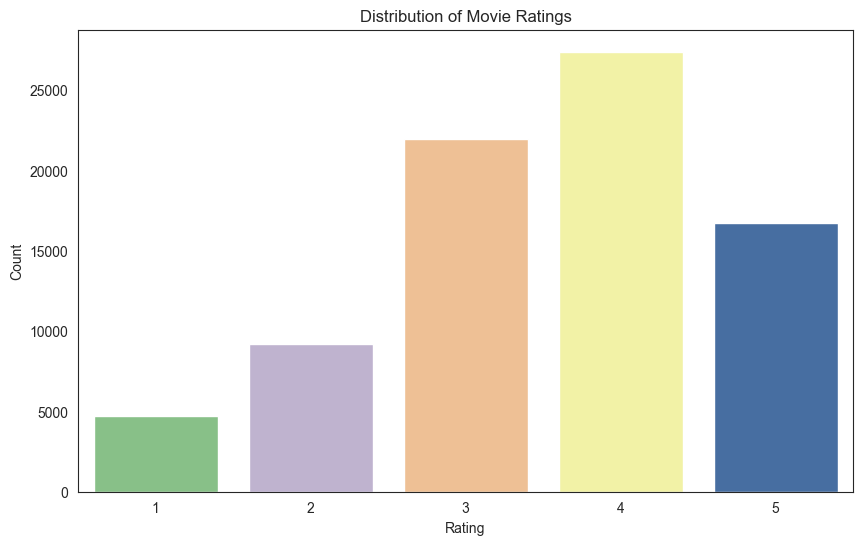

In [2]:
plt.figure(figsize=(10, 6))
sns.set_style("white")
sns.countplot(x='rating', data=movielens_base, palette='Accent')

plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


# Ratings per Movie

/var/folders/hs/0r45q_8x74n4z9f3nmvwypmw0000gn/T/ipykernel_6785/659905728.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='item_id', y='count', data=ratings_per_movie_df, palette='Spectral')


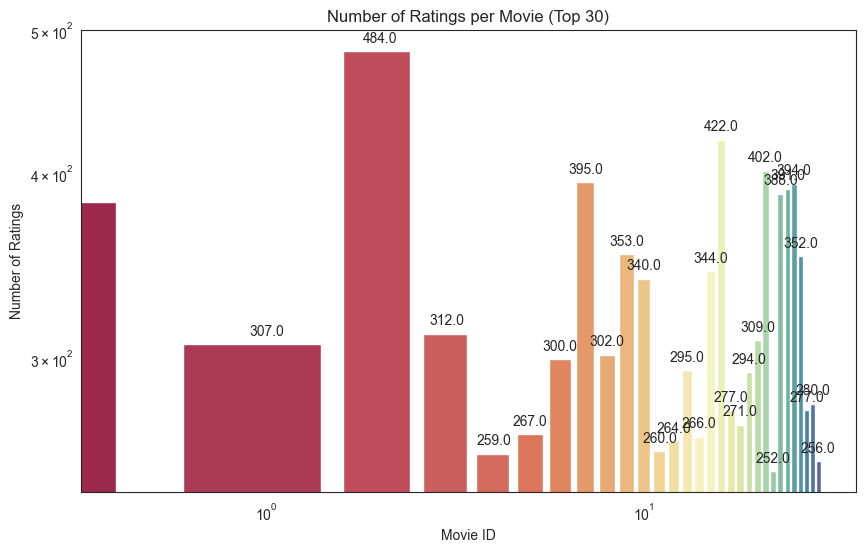

In [3]:
# Calculate the number of ratings per movie and sort
ratings_per_movie = movielens_base.groupby('item_id')['rating'].count().sort_values(ascending=False)

# Convert the Series to DataFrame for easier plotting
ratings_per_movie_df = ratings_per_movie.reset_index(name='count').head(30)  # Limiting to top 30 for clarity

# Create a figure with specified size
plt.figure(figsize=(10, 6))

# Create a colorful bar plot
ax = sns.barplot(x='item_id', y='count', data=ratings_per_movie_df, palette='Spectral')

# Set the title and labels of the plot
plt.title('Number of Ratings per Movie (Top 30)')
plt.xlabel('Movie ID')
plt.ylabel('Number of Ratings')

# Set log scale for both axes
ax.set_yscale('log')
ax.set_xscale('log')

# Annotate the count on top of each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

# Display the plot
plt.show()


# Ratings per User

/var/folders/hs/0r45q_8x74n4z9f3nmvwypmw0000gn/T/ipykernel_6785/66604059.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x_values, y=y_values, palette='coolwarm')


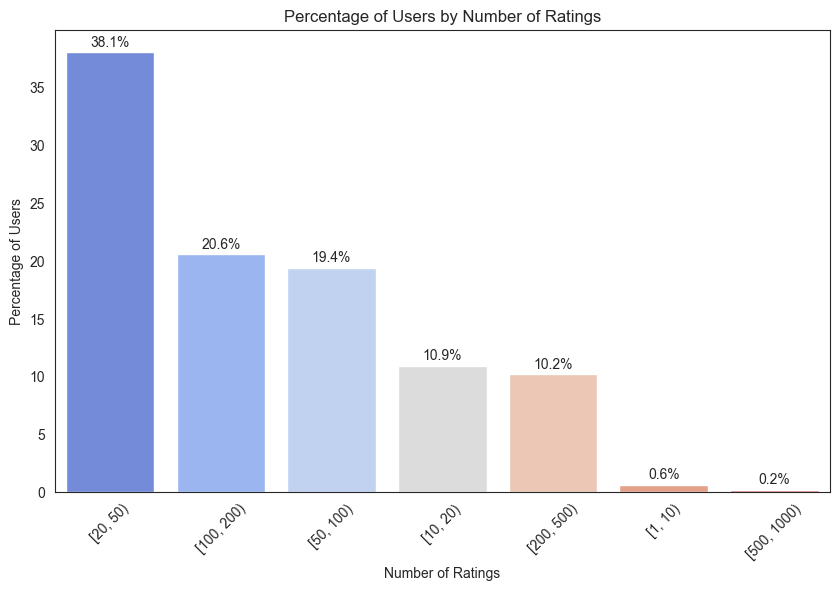

In [4]:

# Calculate the number of ratings per user
ratings_per_user = movielens_base.groupby('user_id')['rating'].count()

# Define bins for the number of ratings
bins = [1, 10, 20, 50, 100, 200, 500, 1000]

# Use pd.cut to categorize users based on the number of ratings they've made
user_bins = pd.cut(ratings_per_user, bins, right=False)

# Calculate the percentage of users in each bin
bin_counts = user_bins.value_counts(normalize=True) * 100

# Convert the Series to DataFrame for easier plotting and reset the index
bin_counts_df = bin_counts.reset_index()
bin_counts_df.columns = ['Rating Range', 'Percentage']  # Explicitly set column names

# Extract x and y values for plotting
x_values = bin_counts_df['Rating Range'].astype(str)  # Convert bin intervals to string
y_values = bin_counts_df['Percentage']

# Create a figure with specified size
plt.figure(figsize=(10, 6))

# Create a colorful bar plot for the percentage of users in each bin
ax = sns.barplot(x=x_values, y=y_values, palette='coolwarm')

# Set the title and labels of the plot
plt.title('Percentage of Users by Number of Ratings')
plt.xlabel('Number of Ratings')
plt.ylabel('Percentage of Users')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Annotate the percentage on top of each bar
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.5, f'{y_values[i]:.1f}%', ha='center')

# Display the plot
plt.show()


# Data Sparsity

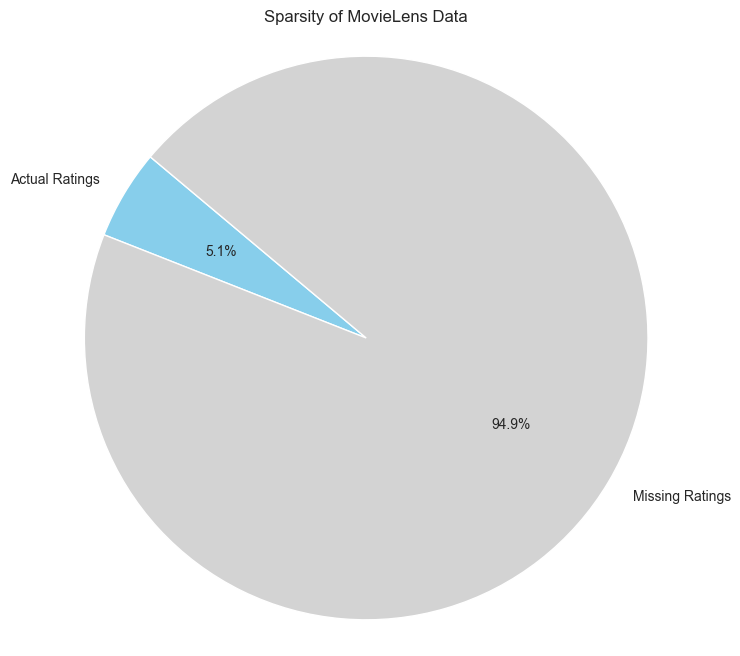

0.948584466081815

In [5]:

# Step 1: Calculate the total number of possible ratings
total_possible_ratings = movielens_base['user_id'].nunique() * movielens_base['item_id'].nunique()

# Step 2: Count the actual number of ratings
actual_ratings = len(movielens_base)

# Step 3: Calculate the sparsity
sparsity = 1 - (actual_ratings / total_possible_ratings)

# Visualize the sparsity
labels = ['Actual Ratings', 'Missing Ratings']
sizes = [actual_ratings, total_possible_ratings - actual_ratings]
colors = ['skyblue', 'lightgrey']

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Sparsity of MovieLens Data')
plt.show()

sparsity



# Average Rating per Movie

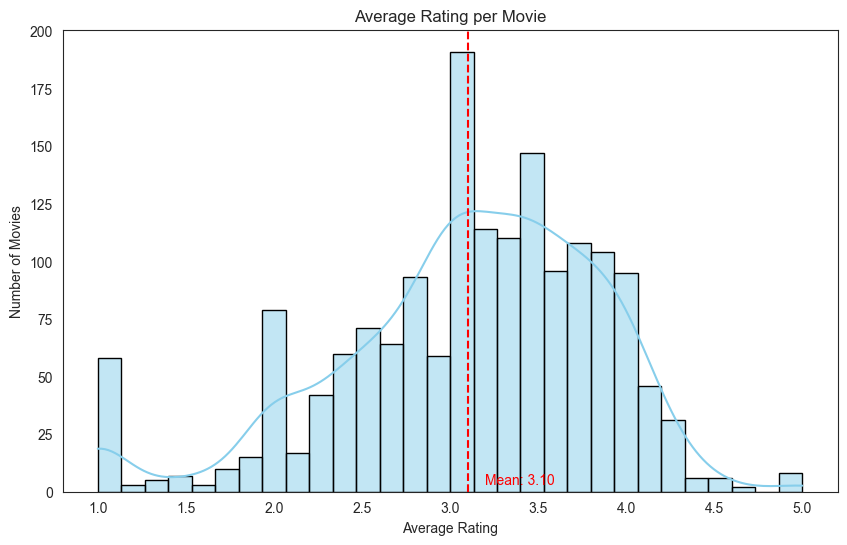

In [6]:
# Calculate the average rating per movie
average_rating_per_movie = movielens_base.groupby('item_id')['rating'].mean()

# Create a figure with specified size
plt.figure(figsize=(10, 6))

# Create a colorful histogram with a KDE plot
sns.histplot(average_rating_per_movie, bins=30, kde=True, color='skyblue', edgecolor='black')

# Calculate and annotate the mean average rating on the plot
mean_average_rating = average_rating_per_movie.mean()
plt.axvline(mean_average_rating, color='red', linestyle='--')
plt.text(mean_average_rating+0.1, 5, f'Mean: {mean_average_rating:.2f}', color='red', verticalalignment='center')

# Set the title and labels of the plot
plt.title('Average Rating per Movie')
plt.xlabel('Average Rating')
plt.ylabel('Number of Movies')

# Display the plot
plt.show()


# Heatmap of User Ratings

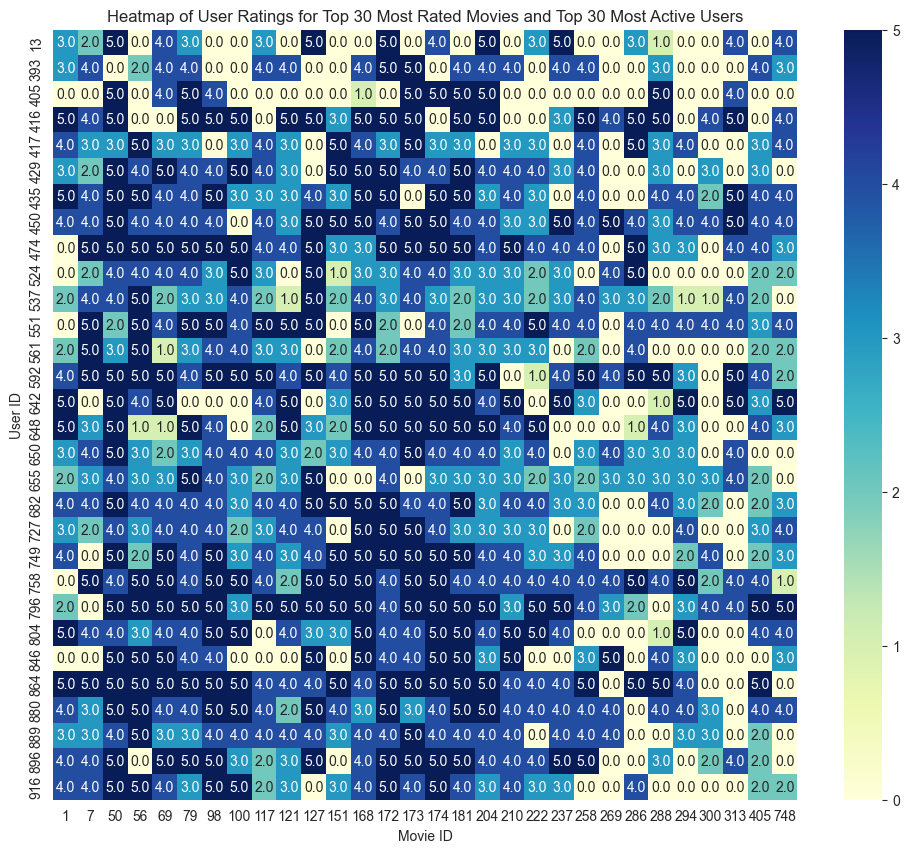

In [7]:


# Select top N most rated movies and top M most active users
top_n_movies = movielens_base['item_id'].value_counts().head(30).index
top_m_users = movielens_base['user_id'].value_counts().head(30).index

# Create a subset of the original dataset with only the top movies and users
ratings_subset = movielens_base[movielens_base['item_id'].isin(top_n_movies) & movielens_base['user_id'].isin(top_m_users)]

# Pivot the table to create a matrix of user ratings for top movies
ratings_matrix = ratings_subset.pivot(index='user_id', columns='item_id', values='rating').fillna(0)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(ratings_matrix, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('Heatmap of User Ratings for Top 30 Most Rated Movies and Top 30 Most Active Users')
plt.xlabel('Movie ID')
plt.ylabel('User ID')
plt.show()


# Cosine Similarity

In [8]:
# Create the user-item matrix
user_item_matrix = movielens_base.pivot_table(index='user_id', columns='item_id', values='rating')


# Assuming user_item_matrix is a pandas DataFrame with users as rows and items as columns.
# Calculate cosine similarity
cosine_sim = cosine_similarity(user_item_matrix.fillna(0))

# Create a DataFrame for the cosine similarity matrix for better readability
cosine_sim_df = pd.DataFrame(cosine_sim, index=user_item_matrix.index, columns=user_item_matrix.index)

# Display the cosine similarity matrix
cosine_sim_df.head()


user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.097021,0.052469,0.021162,0.193545,0.290114,0.200438,0.097786,0.060791,0.200926,...,0.252187,0.090728,0.216186,0.139478,0.156937,0.095265,0.222958,0.158151,0.133090,0.252778
2,0.097021,1.000000,0.051348,0.084426,0.015516,0.187717,0.074479,0.023262,0.108167,0.078176,...,0.083045,0.298811,0.308608,0.403810,0.282896,0.213233,0.189257,0.132806,0.126597,0.101784
3,0.052469,0.051348,1.000000,0.145660,0.037180,0.084526,0.015718,0.086400,0.000000,0.030909,...,0.041330,0.036956,0.135750,0.063940,0.102082,0.034064,0.133720,0.083537,0.081230,0.019676
4,0.021162,0.084426,0.145660,1.000000,0.017291,0.000000,0.037566,0.046087,0.000000,0.023232,...,0.014238,0.047742,0.127305,0.118947,0.089016,0.039116,0.120521,0.135669,0.125925,0.035586
5,0.193545,0.015516,0.037180,0.017291,1.000000,0.158552,0.170890,0.157488,0.053846,0.089508,...,0.284295,0.074215,0.086345,0.063759,0.126358,0.068145,0.198118,0.142141,0.150000,0.239803


# Best RMSE

Similarity Threshold: 0.005, Average RMSE: 0.9167937150454023
Similarity Threshold: 0.01, Average RMSE: 0.9168789849273619
Similarity Threshold: 0.05, Average RMSE: 0.9211491112180848
Similarity Threshold: 0.1, Average RMSE: 0.9220124926611325
Similarity Threshold: 0.2, Average RMSE: 0.936552161236323
Similarity Threshold: 0.3, Average RMSE: 0.9978020892378355
Similarity Threshold: 0.4, Average RMSE: 1.0449592066395668
Similarity Threshold: 0.5, Average RMSE: 1.029521189862431

Best RMSE: 0.9167937150454023 at Similarity Threshold: 0.005


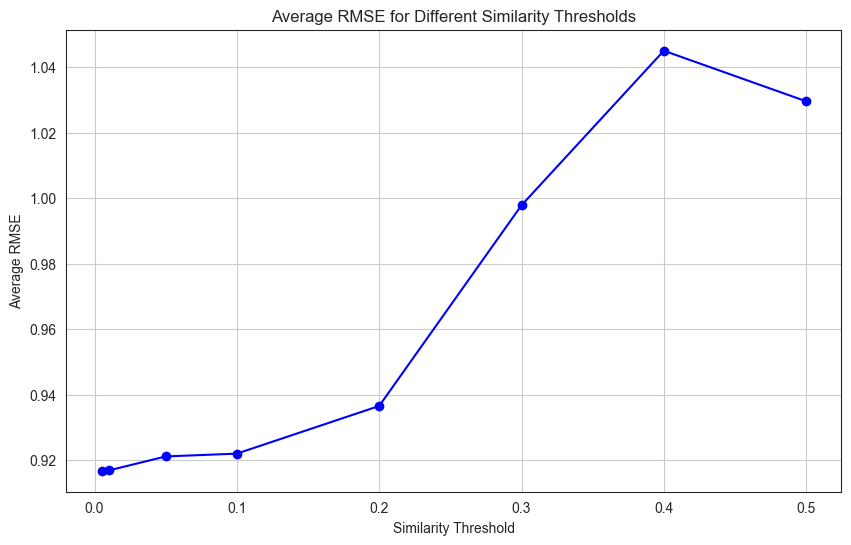

In [9]:
def rmse(predicted_ratings, actual_ratings):
    """
    Calculate the Root Mean Square Error (RMSE) between predicted and actual ratings.
    
    :param predicted_ratings: List of predicted ratings
    :param actual_ratings: List of actual ratings
    :return: The RMSE value
    """
    predicted_ratings = np.array(predicted_ratings)
    actual_ratings = np.array(actual_ratings)
    
    # Calculate the squared differences and their mean
    mse = np.mean((predicted_ratings - actual_ratings) ** 2)
    
    # Return the square root of the mean squared error
    return np.sqrt(mse)



def predict_ratings(user_id, nearest_neighbors, user_item_matrix, similarity_matrix, weighting=True):
    user_avg_rating = np.nanmean(user_item_matrix.loc[user_id])
    
    predictions = {}
    
    for movie_id in user_item_matrix.columns:
        neighbors_ratings = user_item_matrix.loc[nearest_neighbors, movie_id]
        neighbors_similarity = similarity_matrix.loc[user_id, nearest_neighbors]
        
        valid_indices = neighbors_ratings.notna()
        valid_neighbors_ratings = neighbors_ratings[valid_indices]
        valid_neighbors_similarity = neighbors_similarity[valid_indices]
        
        if valid_neighbors_ratings.empty:
            predictions[movie_id] = user_avg_rating
            continue
        
        if weighting:
            weighted_sum = np.dot(valid_neighbors_ratings - np.nanmean(user_item_matrix.loc[valid_neighbors_ratings.index]), valid_neighbors_similarity)
            sim_sum = np.sum(valid_neighbors_similarity)
        else:
            weighted_sum = np.sum(valid_neighbors_ratings - np.nanmean(user_item_matrix.loc[valid_neighbors_ratings.index]))
            sim_sum = len(valid_neighbors_similarity)
        
        if sim_sum > 0:
            predictions[movie_id] = user_avg_rating + (weighted_sum / sim_sum)
        else:
            predictions[movie_id] = user_avg_rating

    return predictions

def find_nearest_neighbors_threshold(user_id, similarity_matrix, threshold=0.2):
    user_similarity_scores = similarity_matrix.loc[user_id]
    nearest_neighbors = user_similarity_scores[user_similarity_scores > threshold].index
    return nearest_neighbors

def evaluate_system(similarity_thresholds, user_ids, user_item_matrix, cosine_sim_df, movielens_test):
    rmse_scores = []
    best_rmse = float('inf')
    best_threshold = None

    for threshold in similarity_thresholds:
        user_rmse_scores = []
        for user_id in user_ids:
            nearest_neighbors = find_nearest_neighbors_threshold(user_id, cosine_sim_df, threshold)
            predicted_ratings = predict_ratings(user_id, nearest_neighbors, user_item_matrix, cosine_sim_df)

            user_actual_ratings_test = movielens_test[movielens_test['user_id'] == user_id]
            actual_ratings_test = user_actual_ratings_test.set_index('item_id')['rating']
            predicted_ratings_test = {item: predicted_ratings.get(item, np.nan) for item in user_actual_ratings_test['item_id']}
            predicted_ratings_test = pd.Series(predicted_ratings_test)

            valid_indices = actual_ratings_test.notna() & predicted_ratings_test.notna()
            if valid_indices.any():
                rmse_score = rmse(predicted_ratings_test[valid_indices], actual_ratings_test[valid_indices])
                user_rmse_scores.append(rmse_score)

        if user_rmse_scores:  # Ensure list is not empty
            avg_rmse = np.mean(user_rmse_scores)
            rmse_scores.append(avg_rmse)
            print(f'Similarity Threshold: {threshold}, Average RMSE: {avg_rmse}')

            if avg_rmse < best_rmse:
                best_rmse = avg_rmse
                best_threshold = threshold

    return best_rmse, best_threshold, rmse_scores



# Define a sample of user IDs to evaluate
sample_user_ids = user_item_matrix.index[:10]  # Adjust this based on your dataset

# Define similarity thresholds to test
similarity_thresholds = [0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

# Execute the evaluation
best_rmse, best_threshold, rmse_scores = evaluate_system(similarity_thresholds, sample_user_ids, user_item_matrix, cosine_sim_df, movielens_test)

# Print the best RMSE and its corresponding threshold
print(f'\nBest RMSE: {best_rmse} at Similarity Threshold: {best_threshold}')

# Plot the RMSE scores for different similarity thresholds
plt.figure(figsize=(10, 6))
plt.plot(similarity_thresholds, rmse_scores, marker='o', linestyle='-', color='b')
plt.title('Average RMSE for Different Similarity Thresholds')
plt.xlabel('Similarity Threshold')
plt.ylabel('Average RMSE')
plt.grid(True)
plt.show()



# Matrix Factorization Techniques

In [10]:

# Function to calculate RMSE
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

# Load the datasets
base_columns = ['user_id', 'item_id', 'rating', 'timestamp']
# Load the base dataset
movielens_base = pd.read_csv('/Users/ninasimone/movielens_100k.base', sep='\t', names=base_columns)

# Load the test dataset
movielens_test = pd.read_csv('/Users/ninasimone/movielens_100k.test', sep='\t', names=test_columns)

# Normalize the ratings in the base dataset
user_mean_ratings = movielens_base.groupby('user_id')['rating'].mean()
normalized_base = movielens_base.copy()
normalized_base['rating'] -= normalized_base['user_id'].map(user_mean_ratings)

# Grid Search with Surprise
reader = Reader(line_format='user item rating timestamp', sep='\t', rating_scale=(1, 5))
data = Dataset.load_from_df(movielens_base[['user_id', 'item_id', 'rating']], reader)
param_grid = {
    'n_factors': [10, 20, 50, 80, 100],
    'n_epochs': [5, 10, 20, 30, 40],
    'lr_all': [0.005, 0.01, 0.02, 0.1, 0.2, 0.5],
    'reg_all': [0.01, 0.02, 0.05, 0.1, 0.2]
}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)
gs.fit(data)

# Best parameters from grid search
best_params = gs.best_params['rmse']
print("Best RMSE from grid search:", gs.best_score['rmse'])
print("Best parameters:", best_params)

# Train final model with best parameters on the full dataset
algo = SVD(n_factors=best_params['n_factors'], n_epochs=best_params['n_epochs'], lr_all=best_params['lr_all'], reg_all=best_params['reg_all'])
trainset = data.build_full_trainset()
algo.fit(trainset)

# Prepare the test set for evaluation
testset = [tuple(row) for row in movielens_test[['user_id', 'item_id', 'rating']].values]
predictions = algo.test(testset)

# Calculate and print the RMSE for the test set
test_rmse = accuracy.rmse(predictions)
print(f"Test RMSE with best parameters: {test_rmse}")



Best RMSE from grid search: 0.9206905159208356
Best parameters: {'n_factors': 100, 'n_epochs': 40, 'lr_all': 0.01, 'reg_all': 0.1}
RMSE: 0.9228
Test RMSE with best parameters: 0.9228181127314412
